In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [60]:
from ipywidgets import IntProgress
from IPython.display import display

In [61]:
from model_builder import ModelBuilder
from solve_action import SolveAction

In [62]:
from pyomo_values_converter import PyomoValuesConverter

In [63]:
from dependencies_calculator import DependenciesCalculator
from cost_calculator_factory import CostCalculatorFactory
from multibinary_converter import MultiBinaryConverter
from multidiscrete_converter import MultiDiscreteConverter
from fitness_calculator import FitnessCalculator

In [64]:
from genetic_multibinary_space_config import GeneticMultiBinarySpaceConfig
from genetic_multidiscrete_space_config import GeneticMultiDiscreteSpaceConfig
from genetic_config import GeneticConfig
from genetic_solver import GeneticSolver

In [65]:
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [66]:
from rl_multibinary_config import RlMultiBinaryConfig
from rl_multidiscrete_config import RlMultiDiscreteConfig
from rl_graphic import RlGraphic
from rl_env import RlEnv
from rl_solver import RlSolver

In [67]:
dtype = np.int64

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
M = 10 ** 6

In [70]:
read_matrix = lambda path: pd.read_csv(path, index_col=0, encoding='utf-8').to_numpy()

In [71]:
C = read_matrix('../publication_4/script/out/C.csv')

In [72]:
D = read_matrix('../publication_4/script/out/D.csv')

In [73]:
Q = read_matrix('../publication_4/script/out/Q.csv')

In [74]:
R = read_matrix('../publication_4/script/out/R.csv')

In [75]:
count = 0
for i in range(len(Q)):
    if (sum(Q[i]) != 1):
        print(i, sum(Q[i]), Q[i])
        count += 1

In [76]:
count

0

In [77]:
constants_file = open('../publication_4/script/out/constants.json', 'r', encoding='utf-8')
constants_data = constants_file.read()
constants_file.close()
constants = json.loads(constants_data)

In [78]:
n = constants['n']
m = constants['m']
l = constants['l']

In [79]:
# solver_name = 'cbc'

In [80]:
calculate_deps_progress = IntProgress(min=0, max=m, value=0, description='deps', bar_style='success')
display(calculate_deps_progress)
deps_calculator = DependenciesCalculator(D, m, calculate_deps_progress)
sum_D = deps_calculator.calculate()

IntProgress(value=0, bar_style='success', description='deps', max=124)

In [81]:
X = np.array([[1] for i in range(m)])

In [82]:
R.dot(Q).dot(sum_D).dot(X)

array([[472.01 ],
       [366.48 ],
       [ 91.   ],
       [226.267],
       [632.4  ],
       [ 59.5  ],
       [ 35.   ],
       [ 16.5  ],
       [ 19.   ],
       [ 77.   ]])

In [83]:
f_in = lambda x: 0 if x == 0 else 1
f_im = lambda x: 0 if x < 1 else 1

In [84]:
result = 0
for requirements in R:
    
    files = np.dot(requirements, Q)
    files_with_dependencies = np.dot(files, sum_D)
    
    plugins = np.dot(files_with_dependencies, X)
    plugins = np.array([f_in(x) for x in plugins])
    
    files_in_delivery = np.dot(X, plugins)
    
    requirements_in_delivery = np.dot(Q, files_in_delivery)
    requirements_in_delivery = np.array([f_im(x) for x in requirements_in_delivery])
    for i in range(len(requirements_in_delivery)):
        if requirements_in_delivery[i] != 1:
            print(i)
            
    
    
    
    prices = np.dot(C, requirements_in_delivery)
    
    cost = np.dot(requirements_in_delivery, prices)
    
    result += cost

In [85]:
0.1 * 5 + 0.5

1.0

In [86]:
Q[34]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0.2, 0.4, 0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [87]:
result

np.float64(1610.0)

In [88]:
class CalculateResult():
    def __init__(self, cost, duration):
        self.cost = cost
        self.duration = duration

In [89]:
def genetic_calculate(k, R):
    config = GeneticConfig()
    config.num_generations = 1000
    multidiscrete_converter = MultiDiscreteConverter(m, k)
    cost_calculator_factory = CostCalculatorFactory(Q, sum_D, C, R)
    multidiscrete_fitness_calculator = FitnessCalculator(M, cost_calculator_factory, multidiscrete_converter)
    multidiscrete_space_config = GeneticMultiDiscreteSpaceConfig(m, k)
    multidiscrete_config = GeneticConfig()
    multibinary_progress = IntProgress(min=0, max=config.num_generations, value=0, description=str(k), bar_style='success')
    multidiscrete_genetic_solver = GeneticSolver(config, multidiscrete_space_config, multidiscrete_fitness_calculator, multibinary_progress)
    # display(multibinary_progress)
    best_solution, best_fitness, best_idx, duration = multidiscrete_genetic_solver.solve()
    A = multidiscrete_converter.convert(best_solution)
    cost_calculator = cost_calculator_factory.get_cost_calculator(A)
    cost = cost_calculator.calculate()
    calculate_result = CalculateResult(cost, duration)
    return calculate_result

In [90]:
def rl_calculate(k, R):
    total_timesteps = 1000
    cost_calculator_factory = CostCalculatorFactory(Q, sum_D, C, R)
    multidiscrete_config = RlMultiDiscreteConfig(m, k, dtype)
    multidiscrete_converter = MultiDiscreteConverter(m, k)
    multidiscrete_fitness_calculator = FitnessCalculator(M, cost_calculator_factory, multidiscrete_converter)
    multidiscrete_progress = IntProgress(min=0, max=total_timesteps, value=0, description=str(k), bar_style='success')
    display(multidiscrete_progress)
    multidiscrete_graphic = RlGraphic('multidiscrete')
    multidiscrete_optimisation_task_env = RlEnv(M, multidiscrete_config, multidiscrete_fitness_calculator, multidiscrete_progress, multidiscrete_graphic)
    check_env(multidiscrete_optimisation_task_env)
    multidiscrete_model = A2C("MlpPolicy", multidiscrete_optimisation_task_env)
    rl_multidiscrete_solver = RlSolver(multidiscrete_model, total_timesteps)
    best_fitness, best_solution, duration = rl_multidiscrete_solver.solve()
    X = multidiscrete_converter.convert(best_solution)
    cost_calculator = cost_calculator_factory.get_cost_calculator(X)
    cost = cost_calculator.calculate()
    calculate_result = CalculateResult(cost, duration)
    return calculate_result

In [91]:
def solver_calculate(k, R, solver_name):
    model_builder = ModelBuilder(M, k, Q, sum_D, C, R)
    model = model_builder.build()
    # solver_name = 'glpk'
    solve_action = SolveAction(model, solver_name)
    solve_result = solve_action.solve()
    instance = solve_result.instance
    duration = solve_result.duration
    pyomo_values_converter = PyomoValuesConverter()
    X = pyomo_values_converter.convert(instance.A)
    cost_calculator_factory = CostCalculatorFactory(Q, sum_D, C, R)
    cost_calculator = cost_calculator_factory.get_cost_calculator(X)
    cost = cost_calculator.calculate()
    calculate_result = CalculateResult(cost, duration)
    return calculate_result

In [92]:
def make_comparation():
    _R = np.array([R[0]])

    genetic_cost = []
    genetic_duration = []

    rl_cost = []
    rl_duration = []
    
    glpk_solver_cost = []
    glpk_solver_duration = []
    
    cbc_solver_cost = []
    cbc_solver_duration = []

    count = 10
    progress = IntProgress(min=0, max=count, value=0, description='progress', bar_style='success')
    display(progress)
    
    for k in range(1, count + 1):
        genetic_calculate_result = genetic_calculate(k, _R)
        # rl_calculate_result = rl_calculate(k, _R)
        # glpk_solver_calculate_result = solver_calculate(k, _R, 'glpk')
        # cbc_solver_calculate_result = solver_calculate(k, _R, 'cbc')

        genetic_cost.append(genetic_calculate_result.cost)
        genetic_duration.append(genetic_calculate_result.duration)

        # rl_cost.append(rl_calculate_result.cost)
        # rl_duration.append(rl_calculate_result.duration)
        
        # glpk_solver_cost.append(glpk_solver_calculate_result.cost)
        # glpk_solver_duration.append(glpk_solver_calculate_result.duration)
        
        # cbc_solver_cost.append(cbc_solver_calculate_result.cost)
        # cbc_solver_duration.append(cbc_solver_calculate_result.duration)
        
        progress.value += 1

    # data = {
    #     'genetic_cost': genetic_cost,
    #     'genetic_duration': genetic_duration,
    #     'solver_cost': solver_cost,
    #     'solver_duration': solver_duration
    # }

    # data = {
    #     'glpk_cost': glpk_solver_cost,
    #     'glpk_duration': glpk_solver_duration,
    #     'cbc_cost': cbc_solver_cost,
    #     'cbc_duration': cbc_solver_duration
    # }

    data = {
        'genetic_cost': genetic_cost,
        'genetic_duration': genetic_duration,
        'rl_cost': rl_cost,
        'rl_duration': rl_duration
    }
    
    df = pd.DataFrame(data)
    return df

In [511]:
comparation_df = make_comparation()

IntProgress(value=0, bar_style='success', description='progress', max=10)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
0.333 + 0.333 + 0.334

In [ ]:
comparation_df

In [505]:
comparation_df.to_csv('out_4/comparation.csv')

In [93]:
def save_k_costs(k, costs, file_name):
    file = open('out_4/' + file_name, 'r', encoding='utf-8')
    data = file.read()
    file.close()
    d = json.loads(data)
    d[str(k)] = costs
    data = json.dumps(d, indent=4)
    file = open('out_4/' + file_name, 'w', encoding='utf-8')
    file.write(data)
    file.close()

In [94]:
def make_genetic(k):
    iterations = 10
    progress = IntProgress(min=0, max=iterations, value=0, description=str(k), bar_style='success')
    display(progress)
    costs = []
    for _ in range(iterations):
        genetic_calculate_result = genetic_calculate(k, R)
        cost = genetic_calculate_result.cost
        costs.append(cost)
        progress.value += 1
    save_k_costs(k, costs, 'genetic.json')

In [95]:
def make_rl(k):
    iterations = 10
    progress = IntProgress(min=0, max=iterations, value=0, description=str(k), bar_style='success')
    display(progress)
    costs = []
    for _ in range(iterations):
        rl_calculate_result = rl_calculate(k, R)
        cost = rl_calculate_result.cost
        costs.append(cost)
        progress.value += 1
    save_k_costs(k, costs, 'rl.json')
    # rl_calculate_result = rl_calculate(k, R)
    # cost = rl_calculate_result.cost
    # return cost

In [96]:
for k in range(1, 51):
    pass
    # make_genetic(k)
    # make_rl(k)

In [48]:
rl_costs = []

In [84]:
rl_df = pd.read_csv('out_4/rl_df.csv', encoding='utf-8')

In [85]:
if False:
    current_step = 1
    steps_count = 50
    rl_progress = IntProgress(min=0, max=steps_count, value=0, description='rl', bar_style='success')
    display(rl_progress)
    for k in range(current_step, current_step + steps_count):
        cost = make_rl(k)
        rl_costs.append(cost)
        rl_progress.value += 1
    rl_dict = {'rl': rl_costs}
    rl_df = pd.DataFrame(rl_dict)
    length = len(rl_df)
    rl_df.index = range(1, length + 1)
    rl_df.to_csv('out_4/rl_df.csv', encoding='utf-8')

In [97]:
genetic_costs_file = open('out_4/genetic.json', 'r', encoding='utf-8')
genetic_costs_data = genetic_costs_file.read()
genetic_costs_file.close()

In [98]:
genetic_costs = json.loads(genetic_costs_data)

In [99]:
genetic_costs_df = pd.DataFrame(genetic_costs)

In [100]:
genetic_costs_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
count,10.0,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.0000,10.00000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1610.0,1610.0,1601.700000,1534.400000,1397.700000,1432.800000,1355.900000,1215.9000,1196.10000,1186.900000,...,642.500000,635.400000,637.300000,625.500000,634.100000,615.900000,605.200000,607.700000,617.400000,602.300000
std,0.0,0.0,26.246905,64.486347,78.443256,64.084666,62.002599,51.2715,53.37592,56.649899,...,35.503521,29.661797,25.394881,27.257007,20.999735,20.458359,24.943492,19.061596,29.368161,30.706677
min,1610.0,1610.0,1527.000000,1425.000000,1289.000000,1338.000000,1219.000000,1142.0000,1108.00000,1094.000000,...,598.000000,586.000000,594.000000,594.000000,590.000000,575.000000,567.000000,571.000000,594.000000,570.000000
25%,1610.0,1610.0,1610.000000,1483.500000,1369.250000,1400.250000,1333.750000,1186.2500,1165.50000,1159.500000,...,618.000000,621.500000,617.250000,609.750000,628.250000,605.250000,592.250000,601.500000,596.250000,579.500000
50%,1610.0,1610.0,1610.000000,1543.500000,1393.500000,1425.500000,1356.000000,1200.5000,1187.50000,1199.000000,...,629.500000,640.500000,645.500000,617.500000,631.000000,618.000000,605.500000,606.000000,608.500000,596.500000
75%,1610.0,1610.0,1610.000000,1595.000000,1415.750000,1478.750000,1384.500000,1244.0000,1219.75000,1219.500000,...,671.750000,653.250000,651.500000,643.750000,645.750000,624.500000,617.750000,620.250000,622.250000,614.000000
max,1610.0,1610.0,1610.000000,1610.000000,1551.000000,1547.000000,1455.000000,1304.0000,1293.00000,1261.000000,...,706.000000,679.000000,676.000000,672.000000,663.000000,644.000000,647.000000,640.000000,683.000000,664.000000


In [101]:
rl_costs_file = open('out_4/rl.json', 'r', encoding='utf-8')
rl_costs_data = rl_costs_file.read()
rl_costs_file.close()

In [102]:
rl_costs = json.loads(rl_costs_data)

In [103]:
rl_costs_df = pd.DataFrame(rl_costs)

In [104]:
rl_costs_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
count,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000
mean,1610.0,1600.300000,1490.800000,1436.400000,1410.500000,1361.200000,1315.700000,1295.700000,1272.400000,1213.900000,...,741.700000,730.100000,729.500000,716.200000,708.600000,701.200000,699.700000,693.20000,690.100000,671.700000
std,0.0,30.674093,5.613476,28.636418,17.494444,24.543838,28.697851,26.457723,24.144012,30.256129,...,13.736003,11.209619,14.713939,13.513779,16.747803,15.164286,14.922392,12.42578,15.968372,16.799802
min,1610.0,1513.000000,1483.000000,1389.000000,1386.000000,1310.000000,1251.000000,1245.000000,1229.000000,1160.000000,...,724.000000,709.000000,712.000000,695.000000,671.000000,681.000000,676.000000,677.00000,659.000000,646.000000
25%,1610.0,1610.000000,1486.750000,1424.000000,1397.500000,1353.250000,1311.750000,1286.000000,1261.250000,1192.500000,...,734.000000,726.250000,716.250000,705.250000,704.500000,687.000000,691.250000,682.50000,680.750000,658.250000
50%,1610.0,1610.000000,1491.000000,1438.000000,1409.500000,1365.000000,1320.000000,1305.000000,1272.500000,1217.500000,...,739.000000,733.000000,728.500000,715.500000,714.000000,704.500000,699.500000,694.50000,692.000000,672.500000
75%,1610.0,1610.000000,1496.000000,1447.500000,1424.250000,1368.750000,1333.500000,1309.000000,1288.500000,1231.000000,...,746.250000,739.000000,739.250000,728.500000,719.250000,711.250000,711.250000,701.75000,698.500000,682.500000
max,1610.0,1610.000000,1498.000000,1493.000000,1436.000000,1404.000000,1354.000000,1334.000000,1308.000000,1257.000000,...,772.000000,741.000000,750.000000,736.000000,725.000000,721.000000,721.000000,710.00000,716.000000,700.000000


In [106]:
genetic_max_values = [genetic_costs_df[stb].max() for stb in genetic_costs_df.columns]
genetc_min_values = [genetic_costs_df[stb].min() for stb in genetic_costs_df.columns]
genetic_mean_values = [genetic_costs_df[stb].mean() for stb in genetic_costs_df.columns]
rl_max_values = [rl_costs_df[stb].max() for stb in rl_costs_df.columns]
rl_min_values = [rl_costs_df[stb].min() for stb in rl_costs_df.columns]
rl_mean_values = [rl_costs_df[stb].mean() for stb in rl_costs_df.columns]

In [119]:
values_dict = {
    'genetic: max': genetic_max_values,
    'genetic: min': genetc_min_values,
    'genetic: mean': genetic_mean_values,
    'rl: max': rl_max_values,
    'rl: min': rl_min_values,
    'rl: mean': rl_mean_values
}

In [120]:
values_df = pd.DataFrame(values_dict)

In [121]:
values_df.index = range(1, 51)

Text(0, 0.5, 'Total requirements implemented')

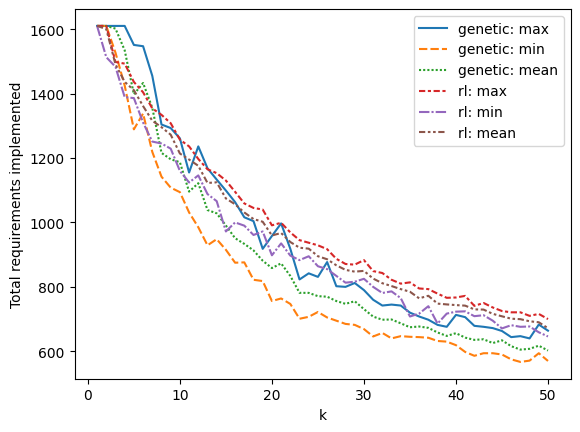

In [122]:
sns.lineplot(data=values_df)
plt.xlabel('k')
plt.ylabel('Total requirements implemented')

Text(0, 0.5, 'Total requirements implemented')

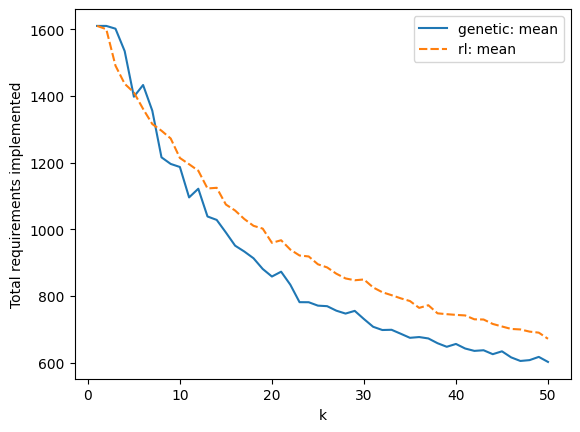

In [124]:
values_dict = {
    'genetic: mean': genetic_mean_values,
    'rl: mean': rl_mean_values
}
values_df = pd.DataFrame(values_dict)
values_df.index = range(1, 51)
sns.lineplot(data=values_df)
plt.xlabel('k')
plt.ylabel('Total requirements implemented')